In [1]:
# Import required libraries
import numpy as np
from keras.models import Sequential
from keras.layers import LSTM, Input, Dropout
from keras.layers import Dense
from keras.layers import RepeatVector
from keras.layers import TimeDistributed
from keras.callbacks import EarlyStopping
from keras.utils.vis_utils import plot_model
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from keras.models import Model, load_model
import seaborn as sns
import datetime
import os.path
import datetime
from importlib import reload

INFO:tensorflow:Enabling eager execution
INFO:tensorflow:Enabling v2 tensorshape
INFO:tensorflow:Enabling resource variables
INFO:tensorflow:Enabling tensor equality
INFO:tensorflow:Enabling control flow v2


In [2]:
# Import self-made modules
from utils import *
from autoencoder import AutoEncoder

In [3]:
# Reload libraries when changes have been made to them
%reload_ext autoreload
%autoreload 2

In [113]:
# Set file path constants
DATA_FILE_PATH = '/Users/jamesmeyer/University of Bath/Patient Simulator FYP - General/datasets/'
DIAGRAM_FILE_PATH = '/Users/jamesmeyer/University of Bath/Patient Simulator FYP - General/diagrams/report/'


In [213]:
# Set parameters
WIN_SIZE = 20
SENSORS = ['back_angle', 'left_angle', 'right_angle']
no_feats = len(SENSORS)

In [214]:
# Obtain training data
file_version = f'ws{WIN_SIZE}num{no_feats}derFalse'
file_name = f'{file_version}-patient-shaved.npy'
path = DATA_FILE_PATH + file_name
trainX = np.load(path)
print(f'Number of control training samples: {trainX.shape}')

Number of control training samples: (38167, 20, 3)


In [215]:
# Retrieve test data for plotting and place with pd dataframe
patient_file_path = '/Users/jamesmeyer/University of Bath/Patient Simulator FYP - General/datasets/patient/patient_data.csv'
dataframe = pd.read_csv(patient_file_path, parse_dates=['datetime'])
df = dataframe.loc[:,SENSORS]
df.loc[:,'Date'] = pd.to_datetime(dataframe.loc[:,'datetime'])

df.dtypes

back_angle            float64
left_angle            float64
right_angle           float64
Date           datetime64[ns]
dtype: object

In [216]:
quart_time_code = '185000_0428'
quart_model_file = f'{quart_time_code}-model.h5'
quart_model_file

'185000_0428-model.h5'

In [217]:
# Fit the model
quart = AutoEncoder(None, None, None, None,quart_model_file, DIAGRAM_FILE_PATH)

Checking for 185000_0428-model.h5

Model loaded from: 185000_0428-model.h5
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 15)                1140      
_________________________________________________________________
dropout (Dropout)            (None, 15)                0         
_________________________________________________________________
repeat_vector (RepeatVector) (None, 20, 15)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 20, 15)            1860      
_________________________________________________________________
dropout_1 (Dropout)          (None, 20, 15)            0         
_________________________________________________________________
time_distributed (TimeDistri (None, 20, 3)             48        
Total params: 3,048
Trainable params: 3,048
Non

In [218]:
predictX = quart.model.predict(trainX)

In [219]:
predict = recombine_signals(predictX)
predict

(38187, 3)


array([[0.26536289, 0.24060723, 0.12367555],
       [0.41373366, 0.35912783, 0.17591402],
       [0.49382466, 0.41540384, 0.19972971],
       ...,
       [0.48794074, 0.24026129, 0.33858597],
       [0.32634032, 0.15976852, 0.22625801],
       [0.        , 0.        , 0.        ]])

In [220]:
df.loc[:, ['back_hat', 'left_hat', 'right_hat']] = predict
df

,back_angle,left_angle,right_angle,Date,back_hat,left_hat,right_hat
0,0.424307,0.572584,0.215395,2011-12-01 11:04:05.000,0.265363,0.240607,0.123676
1,0.456290,0.568733,0.200416,2011-12-01 11:04:05.050,0.413734,0.359128,0.175914
2,0.488273,0.564883,0.200416,2011-12-01 11:04:05.100,0.493825,0.415404,0.199730
3,0.530917,0.557181,0.201110,2011-12-01 11:04:05.150,0.538075,0.441394,0.210759
4,0.573561,0.541779,0.200416,2011-12-01 11:04:05.200,0.562050,0.452929,0.216131
...,...,...,...,...,...,...,...
38182,0.626866,0.276088,0.527046,2011-12-01 11:35:54.100,0.602111,0.301232,0.423159
38183,0.626866,0.276088,0.525659,2011-12-01 11:35:54.150,0.566327,0.280790,0.394679
38184,0.616205,0.276088,0.524272,2011-12-01 11:35:54.200,0.487941,0.240261,0.338586
38185,0.616205,0.276088,0.524272,2011-12-01 11:35:54.250,0.326340,0.159769,0.226258


<module 'matplotlib.pyplot' from '/Users/jamesmeyer/.pyenv/versions/fyp-env/lib/python3.9/site-packages/matplotlib/pyplot.py'>

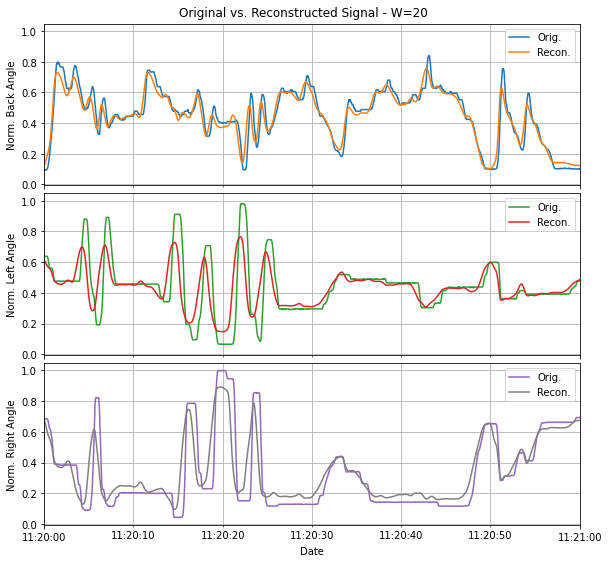

In [221]:
start = datetime.datetime(2011, 12, 1, 11, 20, 00)
end = datetime.datetime(2011, 12, 1, 11, 21, 00)
full_reconstruct_plot(df, 'mean', 'W=20', DIAGRAM_FILE_PATH, start, end, False)

Saved as: /Users/jamesmeyer/University of Bath/Patient Simulator FYP - General/diagrams/report/eg-window-19380-W=20-2.png


<module 'matplotlib.pyplot' from '/Users/jamesmeyer/.pyenv/versions/fyp-env/lib/python3.9/site-packages/matplotlib/pyplot.py'>

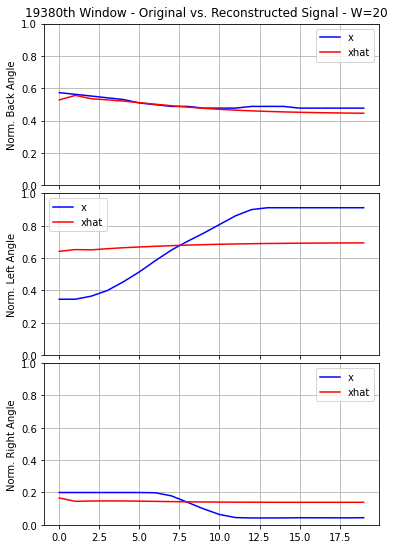

In [222]:
example_plot(19380, no_feats, WIN_SIZE, trainX, predictX, f'W={WIN_SIZE}', DIAGRAM_FILE_PATH, True)

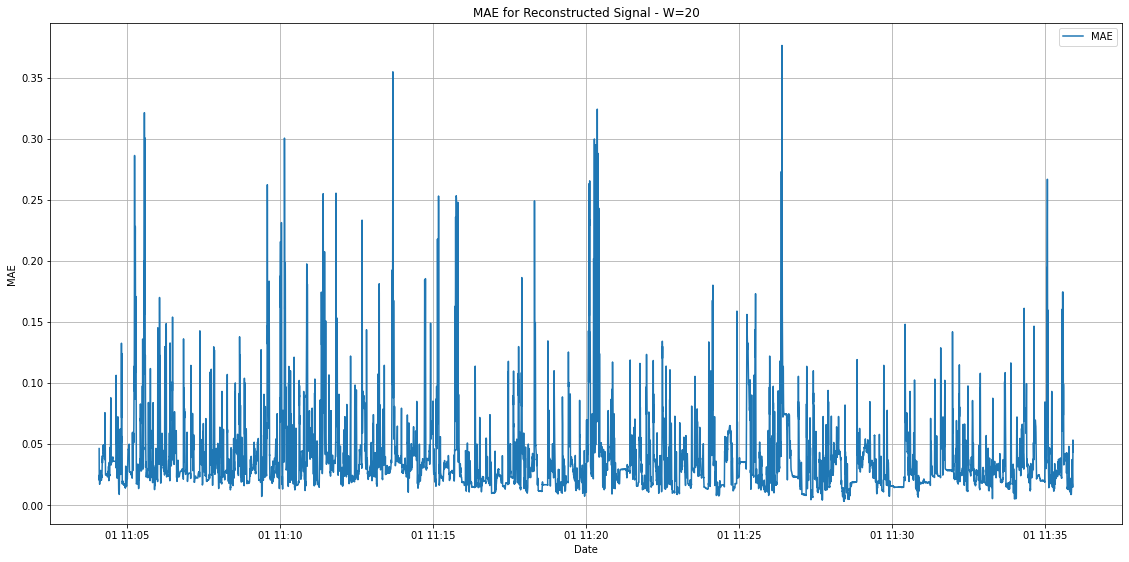

In [223]:
error = error_computation(trainX, predictX)
error_df = anomaly_df(df, WIN_SIZE, error, 0)
_, plot = error_vs_thresh_plot_and_save(error_df, 'MAE', f'W={WIN_SIZE}', DIAGRAM_FILE_PATH, pct=None, save_new=False)

In [ ]:
_, plot = error_vs_thresh_plot_and_save(error_df, 'MAE', f'W={WIN_SIZE}', DIAGRAM_FILE_PATH, pct=None, tstart=start, tend=end, save_new=False)

In [224]:
# Set parameters
WIN_SIZE = 60
SENSORS = ['back_angle', 'left_angle', 'right_angle']
no_feats = len(SENSORS)

In [225]:
# Obtain training data
file_version = f'ws{WIN_SIZE}num{no_feats}derFalse'
file_name = f'{file_version}-patient-shaved.npy'
path = DATA_FILE_PATH + file_name
trainX = np.load(path)
print(f'Number of control training samples: {trainX.shape}')

Number of control training samples: (38127, 60, 3)


In [226]:
sixty_time_code = '192500_0428'
sixty_model_file = f'{sixty_time_code}-model.h5'
sixty_model_file

'192500_0428-model.h5'

In [227]:
sixty = AutoEncoder(None, None, None, None, sixty_model_file, DIAGRAM_FILE_PATH)

Checking for 192500_0428-model.h5

Model loaded from: 192500_0428-model.h5
Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_6 (LSTM)                (None, 45)                8820      
_________________________________________________________________
dropout_6 (Dropout)          (None, 45)                0         
_________________________________________________________________
repeat_vector_3 (RepeatVecto (None, 60, 45)            0         
_________________________________________________________________
lstm_7 (LSTM)                (None, 60, 45)            16380     
_________________________________________________________________
dropout_7 (Dropout)          (None, 60, 45)            0         
_________________________________________________________________
time_distributed_3 (TimeDist (None, 60, 3)             138       
Total params: 25,338
Trainable params: 25,338

In [228]:
predictX = sixty.model.predict(trainX)
predict = recombine_signals(predictX)
predict

(38187, 3)


array([[0.27750725, 0.22636986, 0.12312883],
       [0.42618355, 0.34602709, 0.17488915],
       [0.50480258, 0.40449967, 0.20001037],
       ...,
       [0.40217111, 0.24982054, 0.36352597],
       [0.27096549, 0.1653018 , 0.24128625],
       [0.        , 0.        , 0.        ]])

In [229]:
df.loc[:, ['back_hat', 'left_hat', 'right_hat']] = predict
df

,back_angle,left_angle,right_angle,Date,back_hat,left_hat,right_hat
0,0.424307,0.572584,0.215395,2011-12-01 11:04:05.000,0.277507,0.226370,0.123129
1,0.456290,0.568733,0.200416,2011-12-01 11:04:05.050,0.426184,0.346027,0.174889
2,0.488273,0.564883,0.200416,2011-12-01 11:04:05.100,0.504803,0.404500,0.200010
3,0.530917,0.557181,0.201110,2011-12-01 11:04:05.150,0.547296,0.432103,0.212462
4,0.573561,0.541779,0.200416,2011-12-01 11:04:05.200,0.570079,0.444676,0.218981
...,...,...,...,...,...,...,...
38182,0.626866,0.276088,0.527046,2011-12-01 11:35:54.100,0.490658,0.316556,0.459263
38183,0.626866,0.276088,0.525659,2011-12-01 11:35:54.150,0.463886,0.293491,0.426231
38184,0.616205,0.276088,0.524272,2011-12-01 11:35:54.200,0.402171,0.249821,0.363526
38185,0.616205,0.276088,0.524272,2011-12-01 11:35:54.250,0.270965,0.165302,0.241286


<module 'matplotlib.pyplot' from '/Users/jamesmeyer/.pyenv/versions/fyp-env/lib/python3.9/site-packages/matplotlib/pyplot.py'>

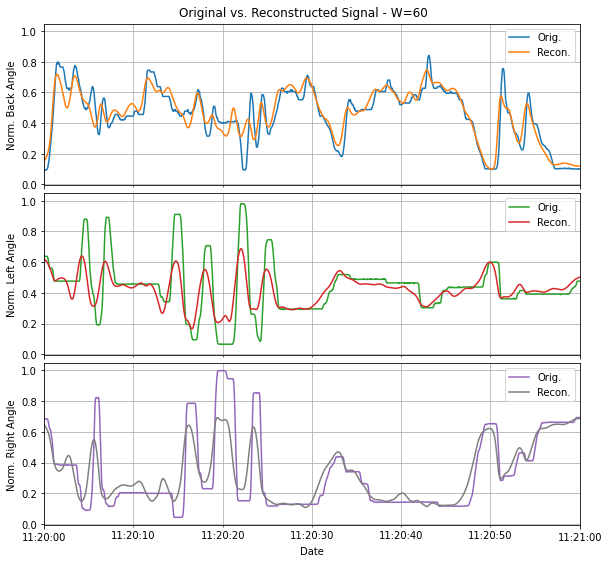

In [230]:
start = datetime.datetime(2011, 12, 1, 11, 20, 00)
end = datetime.datetime(2011, 12, 1, 11, 21, 00)
full_reconstruct_plot(df, 'mean', 'W=60', DIAGRAM_FILE_PATH, start, end, False)

Saved as: /Users/jamesmeyer/University of Bath/Patient Simulator FYP - General/diagrams/report/eg-window-19380-W=60-2.png


<module 'matplotlib.pyplot' from '/Users/jamesmeyer/.pyenv/versions/fyp-env/lib/python3.9/site-packages/matplotlib/pyplot.py'>

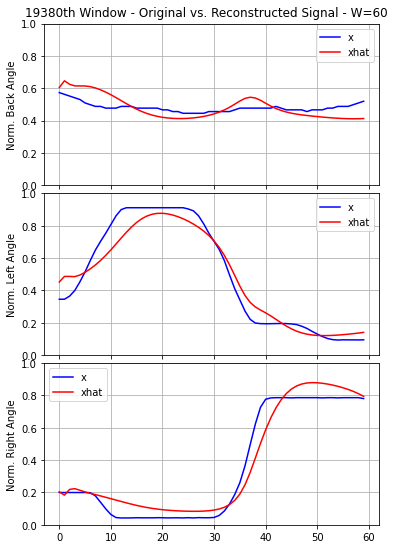

In [231]:
example_plot(19380, no_feats, WIN_SIZE, trainX, predictX, f'W={WIN_SIZE}', DIAGRAM_FILE_PATH, True)

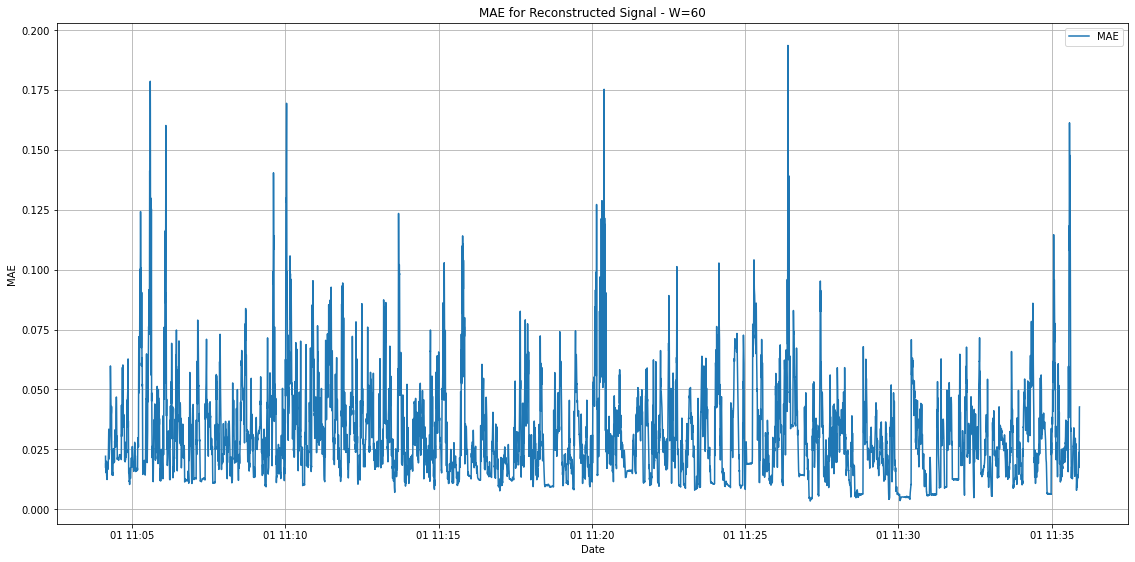

In [232]:
error = error_computation(trainX, predictX)
error_df = anomaly_df(df, WIN_SIZE, error, 0)
_, plot = error_vs_thresh_plot_and_save(error_df, 'MAE', f'W={WIN_SIZE}', DIAGRAM_FILE_PATH, pct=None, save_new=False)

In [ ]:
_, plot = error_vs_thresh_plot_and_save(error_df, 'MAE', f'W={WIN_SIZE}', DIAGRAM_FILE_PATH, pct=None, tstart=start, tend=end, save_new=False)

In [233]:
# Set parameters
WIN_SIZE = 100
SENSORS = ['back_angle', 'left_angle', 'right_angle']
no_feats = len(SENSORS)

In [234]:
# Obtain training data
file_version = f'ws{WIN_SIZE}num{no_feats}derFalse'
file_name = f'{file_version}-patient-shaved.npy'
path = DATA_FILE_PATH + file_name
trainX = np.load(path)
print(f'Number of control training samples: {trainX.shape}')

Number of control training samples: (38087, 100, 3)


In [235]:
hund_time_code = '193000_0428'
hund_model_file = f'{hund_time_code}-model.h5'
hund_model_file

'193000_0428-model.h5'

In [236]:
hund = AutoEncoder(None, None, None, None, hund_model_file, DIAGRAM_FILE_PATH)

Checking for 193000_0428-model.h5

Model loaded from: 193000_0428-model.h5
Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_8 (LSTM)                (None, 75)                23700     
_________________________________________________________________
dropout_8 (Dropout)          (None, 75)                0         
_________________________________________________________________
repeat_vector_4 (RepeatVecto (None, 100, 75)           0         
_________________________________________________________________
lstm_9 (LSTM)                (None, 100, 75)           45300     
_________________________________________________________________
dropout_9 (Dropout)          (None, 100, 75)           0         
_________________________________________________________________
time_distributed_4 (TimeDist (None, 100, 3)            228       
Total params: 69,228
Trainable params: 69,228

In [237]:
predictX = hund.model.predict(trainX)
predict = recombine_signals(predictX)
predict

(38187, 3)


array([[0.26435786, 0.24081489, 0.12079285],
       [0.40489531, 0.36495905, 0.17207959],
       [0.4795153 , 0.42537596, 0.19664256],
       ...,
       [0.39255643, 0.2597458 , 0.36559436],
       [0.26465642, 0.17207125, 0.24268784],
       [0.        , 0.        , 0.        ]])

In [238]:
df.loc[:, ['back_hat', 'left_hat', 'right_hat']] = predict
df

,back_angle,left_angle,right_angle,Date,back_hat,left_hat,right_hat
0,0.424307,0.572584,0.215395,2011-12-01 11:04:05.000,0.264358,0.240815,0.120793
1,0.456290,0.568733,0.200416,2011-12-01 11:04:05.050,0.404895,0.364959,0.172080
2,0.488273,0.564883,0.200416,2011-12-01 11:04:05.100,0.479515,0.425376,0.196643
3,0.530917,0.557181,0.201110,2011-12-01 11:04:05.150,0.519723,0.453995,0.208501
4,0.573561,0.541779,0.200416,2011-12-01 11:04:05.200,0.541029,0.467083,0.214513
...,...,...,...,...,...,...,...
38182,0.626866,0.276088,0.527046,2011-12-01 11:35:54.100,0.481294,0.327731,0.460532
38183,0.626866,0.276088,0.525659,2011-12-01 11:35:54.150,0.453397,0.304602,0.428216
38184,0.616205,0.276088,0.524272,2011-12-01 11:35:54.200,0.392556,0.259746,0.365594
38185,0.616205,0.276088,0.524272,2011-12-01 11:35:54.250,0.264656,0.172071,0.242688


<module 'matplotlib.pyplot' from '/Users/jamesmeyer/.pyenv/versions/fyp-env/lib/python3.9/site-packages/matplotlib/pyplot.py'>

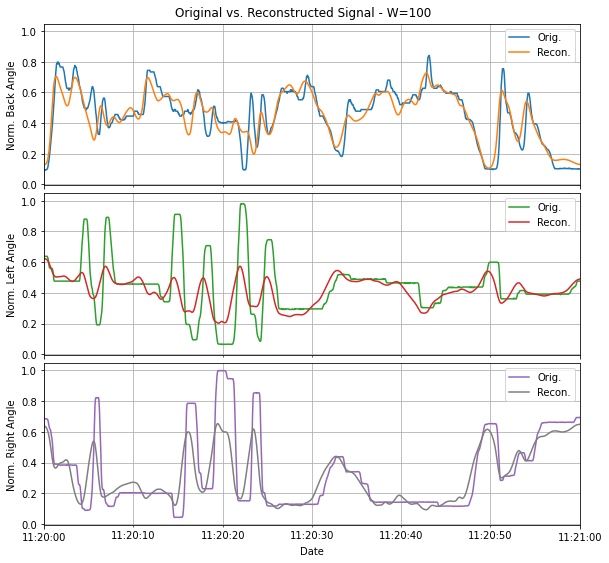

In [239]:
start = datetime.datetime(2011, 12, 1, 11, 20, 00)
end = datetime.datetime(2011, 12, 1, 11, 21, 00)
full_reconstruct_plot(df, 'mean', 'W=100', DIAGRAM_FILE_PATH, start, end, False)

<module 'matplotlib.pyplot' from '/Users/jamesmeyer/.pyenv/versions/fyp-env/lib/python3.9/site-packages/matplotlib/pyplot.py'>

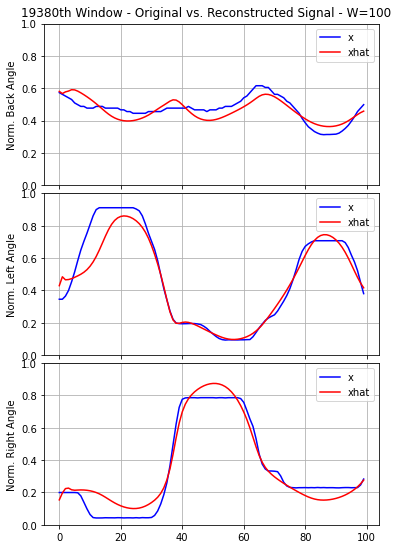

In [240]:
example_plot(19380, no_feats, WIN_SIZE, trainX, predictX, f'W={WIN_SIZE}', DIAGRAM_FILE_PATH, False)

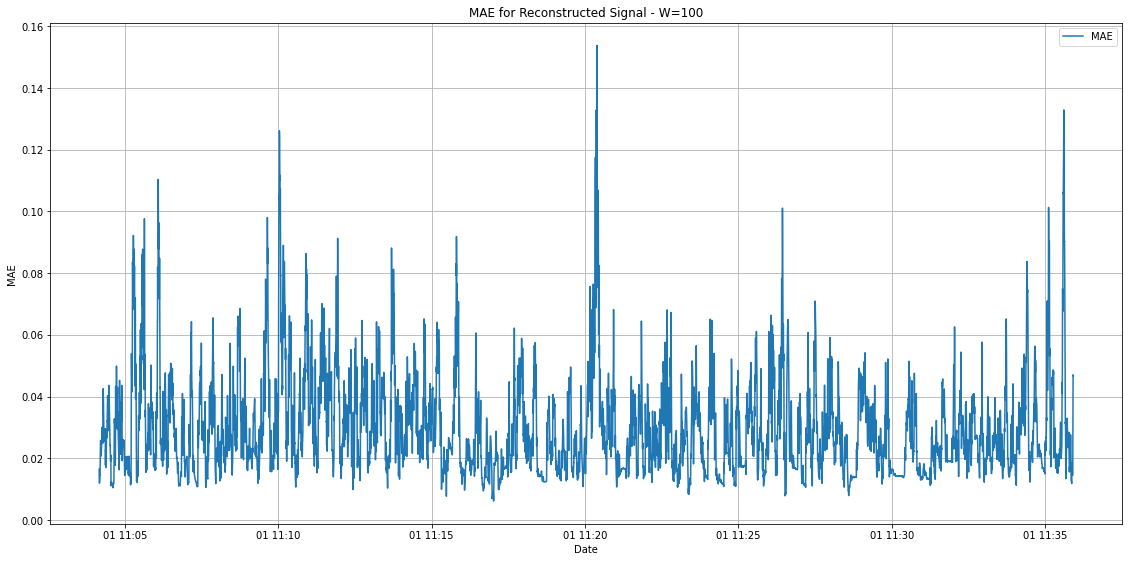

In [241]:
error = error_computation(trainX, predictX)
error_df = anomaly_df(df, WIN_SIZE, error, 0)
_, plot = error_vs_thresh_plot_and_save(error_df, 'MAE', f'W={WIN_SIZE}', DIAGRAM_FILE_PATH, pct=None, save_new=False)

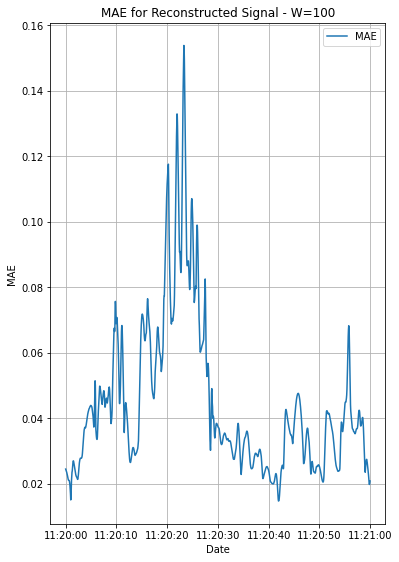

In [243]:
_, plot = error_vs_thresh_plot_and_save(error_df, 'MAE', f'W={WIN_SIZE}', DIAGRAM_FILE_PATH, pct=None, tstart=start, tend=end, save_new=False)